<a href="https://colab.research.google.com/github/Mehrnoushhk/DeepLearning/blob/master/PinAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import datetime

In [8]:
from DataCleaner import dataCleaner
from DataCleaner import localMin
from DataCleaner import localMax
from DataCleaner import nextHigh
from DataCleaner import nextLow
from DataCleaner import previousHigh
from DataCleaner import previousLow


In [9]:
# Reading data
url= 'https://raw.githubusercontent.com/Mehrnoushhk/DeepLearning/master/GBPUSDm30.csv'
data= pd.read_csv(url) 
data= dataCleaner(data)

In [10]:
#%%time
dataMax, dataMaxValue= localMax(data, 4)
dataMin, dataMinValue= localMin(data, 4)

In [11]:
data['isMax']= dataMax
data['maxValue']= dataMaxValue
data['isMin']= dataMin
data['minValue']= dataMinValue

In [12]:
minMax= pd.DataFrame(list(zip(dataMinValue, dataMaxValue)), columns=['min', 'Max'])

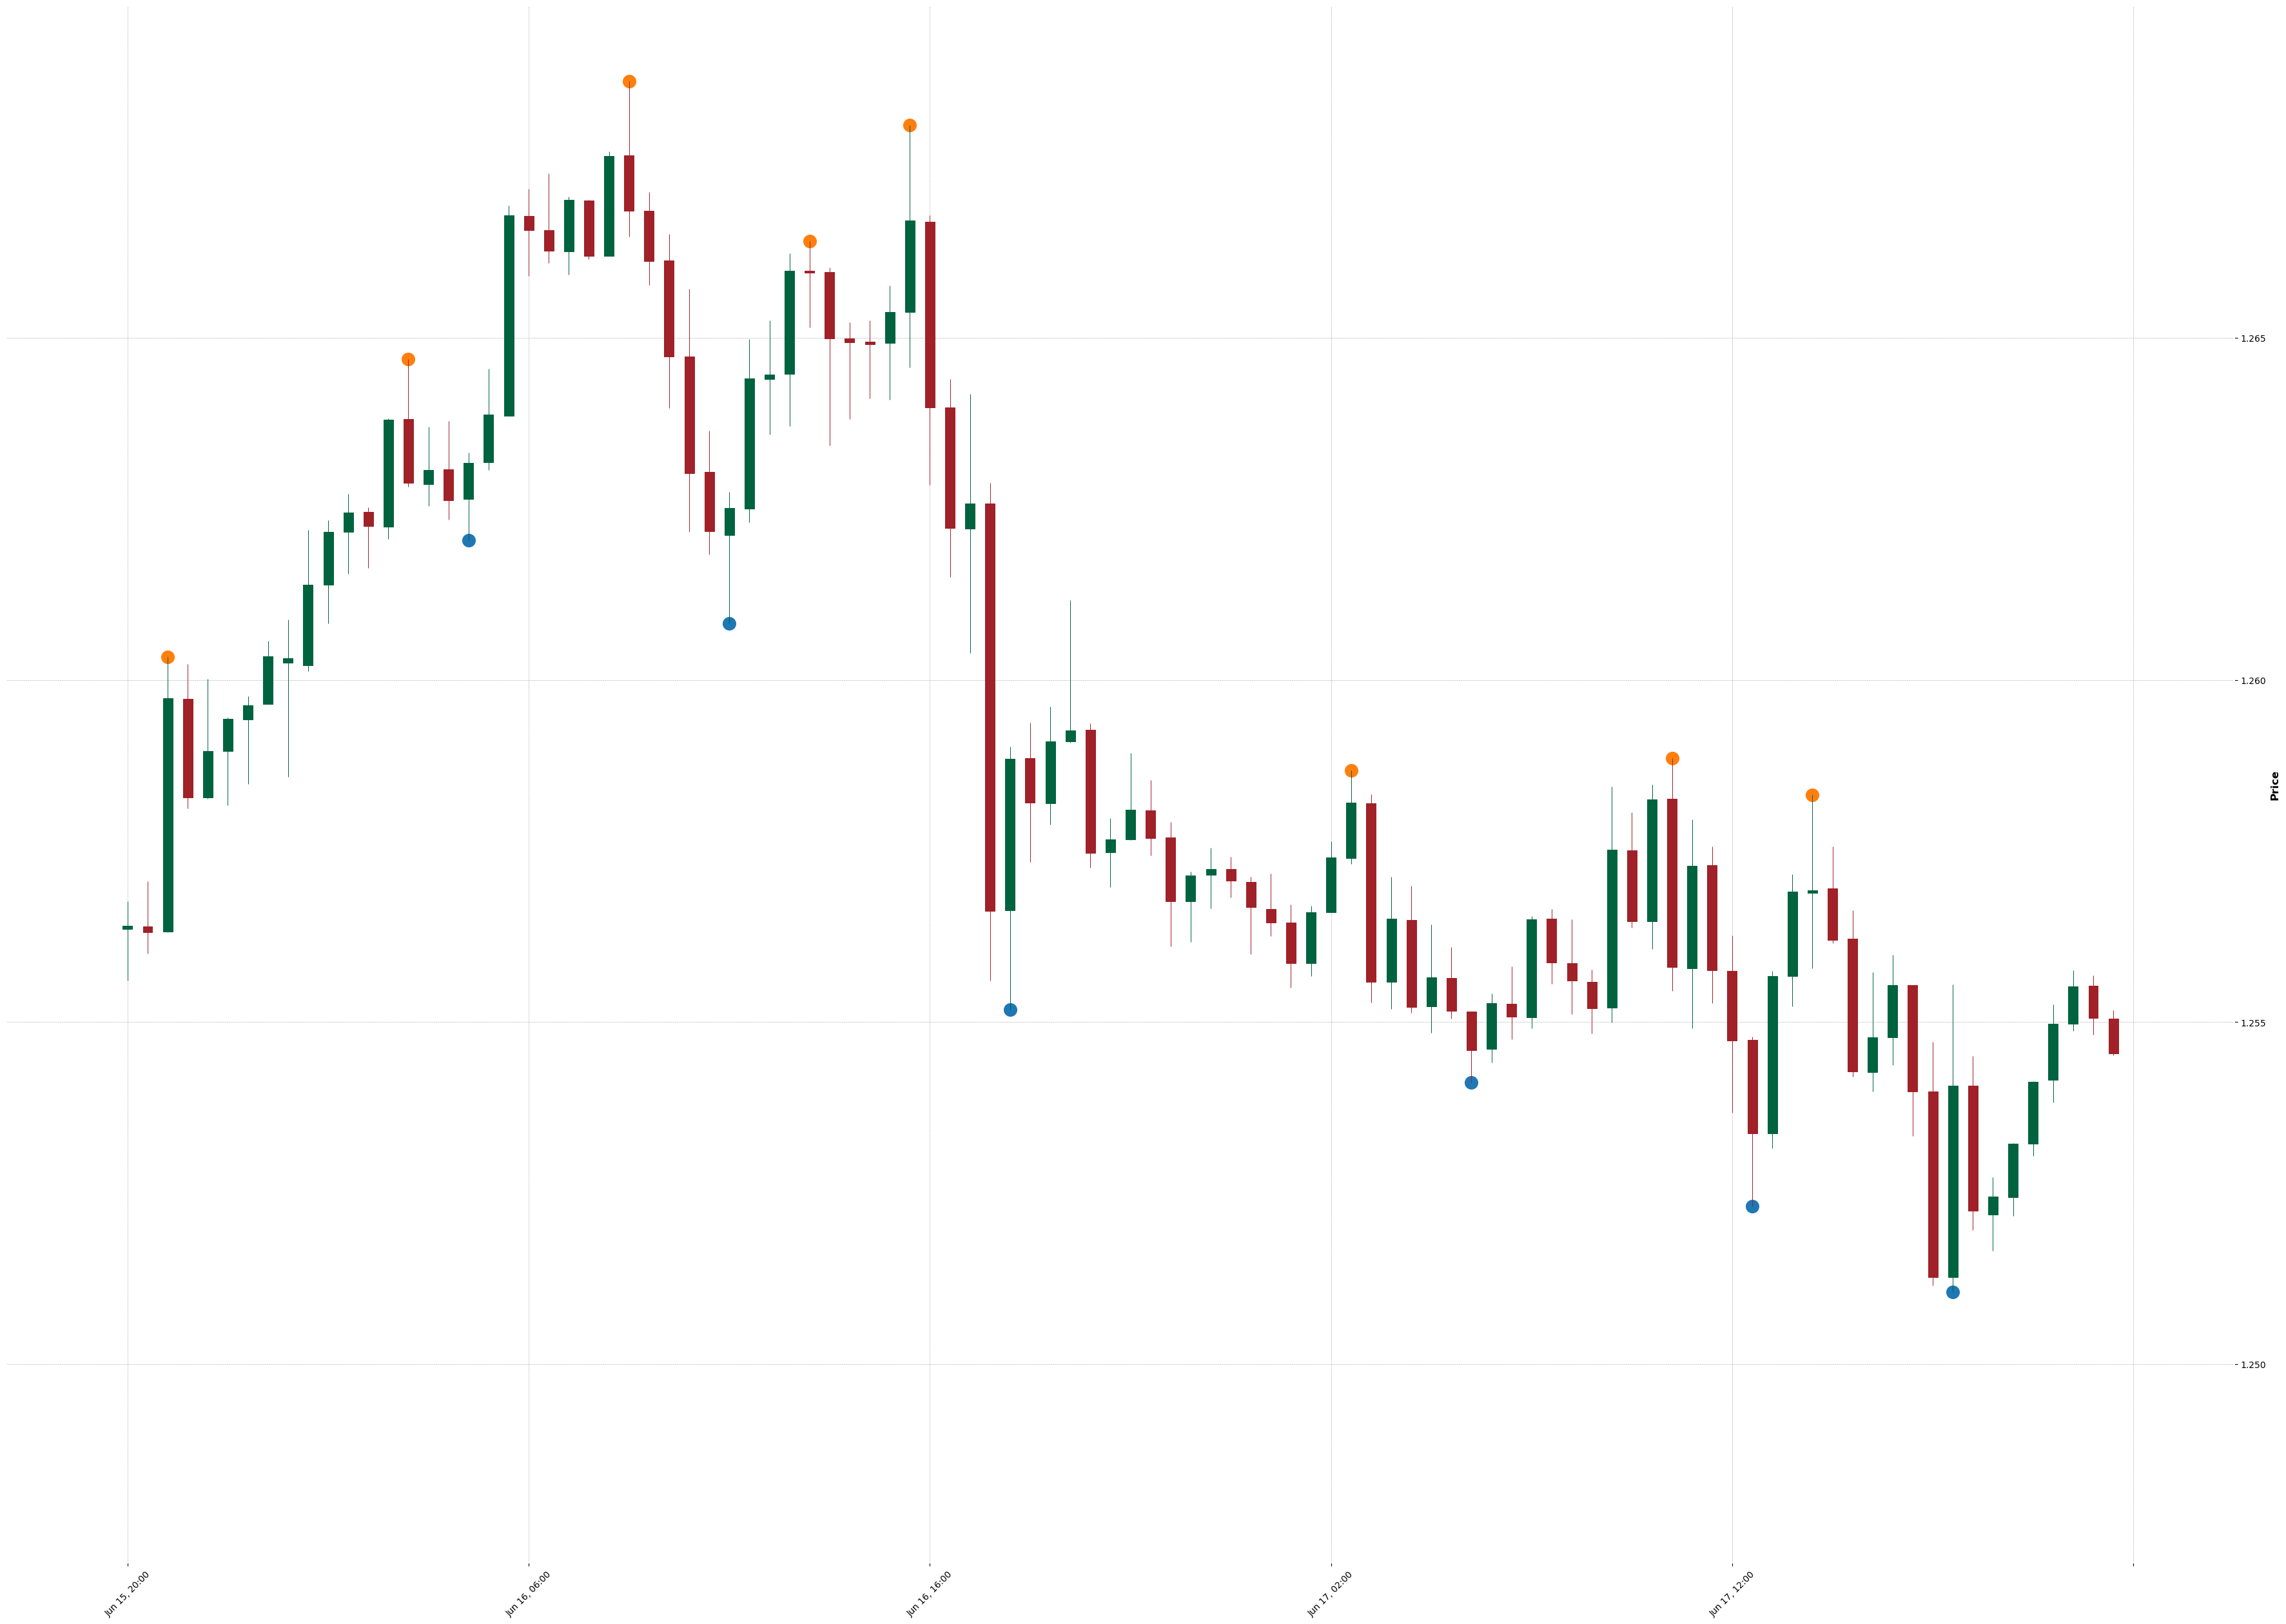

In [13]:
import mplfinance as mpl
adp= mpl.make_addplot(minMax[len(minMax)-100:], type= 'scatter', markersize= 200)
mpl.plot(data.iloc[data.shape[0]-100: data.shape[0],:], type= 'candle', style= 'charles', figscale= 6, addplot= adp)

In [14]:
isMaxid= 6
maxValueid= 7
isMinid= 8
minValueid= 9
Trendid= 10

In [20]:
from DataCleaner import nextTrend
for i in range(0, data.shape[0]):
    data['Trend']= nextTrend(data, i)

ImportError: cannot import name 'nextTrend' from 'DataCleaner' (c:\Users\ss\Documents\GitHub\DeepLearning\DataCleaner.py)

In [55]:
trendDetector(data, 5574)

Next High is 1.29587
Next Low is 1.29902
Previous Low is 1.29364


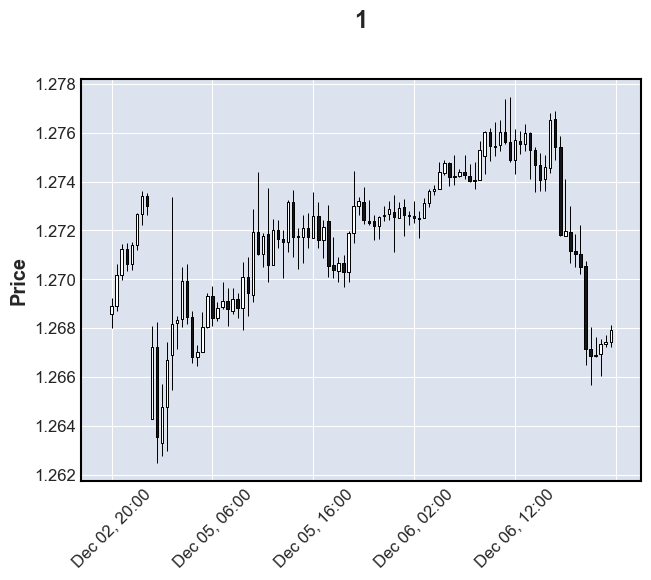

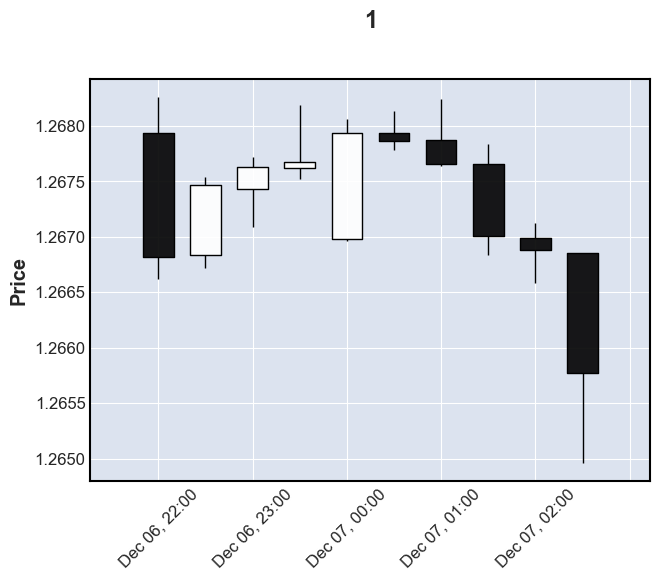

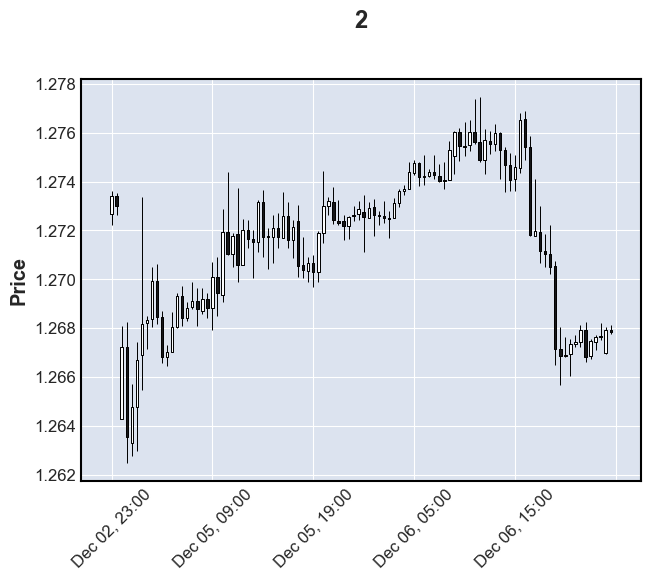

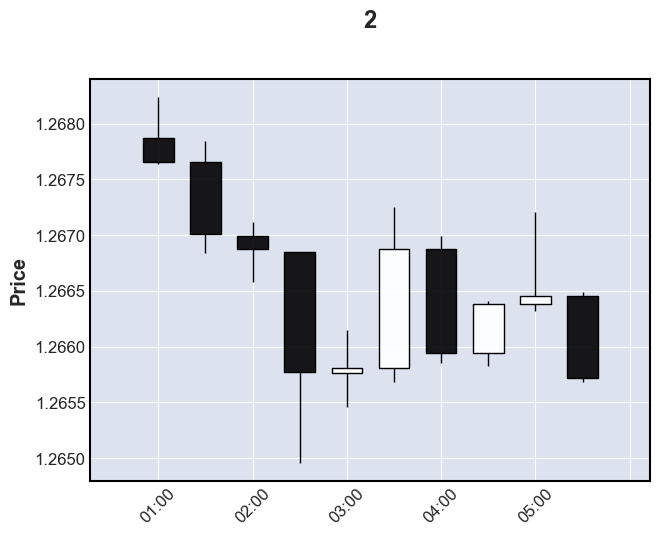

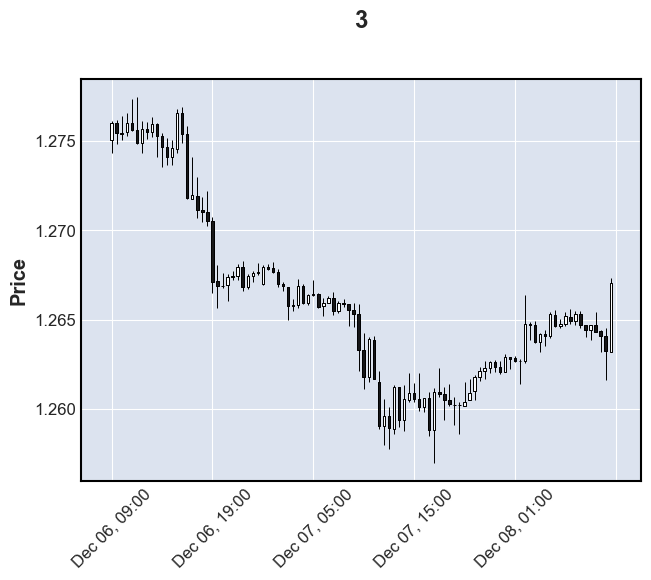

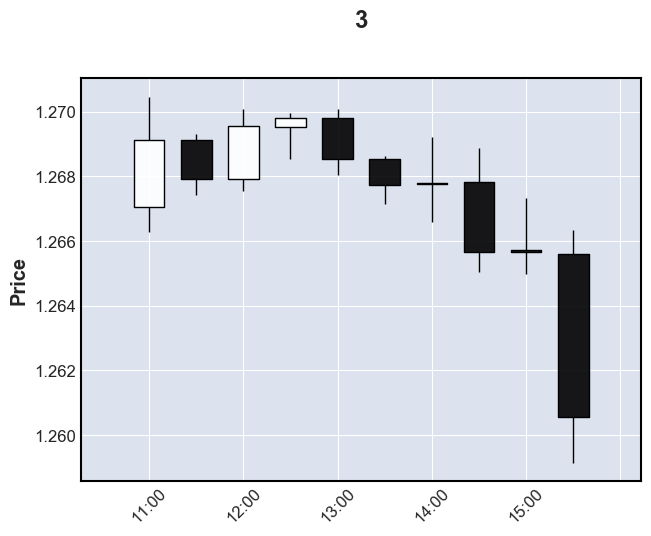

In [53]:
counter= 1
for i in range(100, 200):
    if data.iloc[i, trendid]== 1:
        mpl.plot(data.iloc[i-100:i, :], type= 'candle', title= str(counter))
        mpl.plot(data.iloc[i: i+10,:], type= 'candle', title= str(counter))
        counter= counter+ 1

In [50]:
pip install --upgrade mplfinance


  Attempting uninstall: mplfinance
    Found existing installation: mplfinance 0.12.5a2
    Uninstalling mplfinance-0.12.5a2:
      Successfully uninstalled mplfinance-0.12.5a2
